In [44]:
import pandas as pd
import string
import nltk
import pymorphy2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import xgboost as xgb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
morph = pymorphy2.MorphAnalyzer()

# Загрузка и предобработка датафрейма
df = pd.read_excel('Ferguson.xlsx')
df = df.dropna(axis=1, how='all')
df = df.dropna(subset=['tweet', 'sentiment'])

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\aomurbaeva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Распределение классов:
sentiment
3    646
2    369
1    190
Name: count, dtype: int64


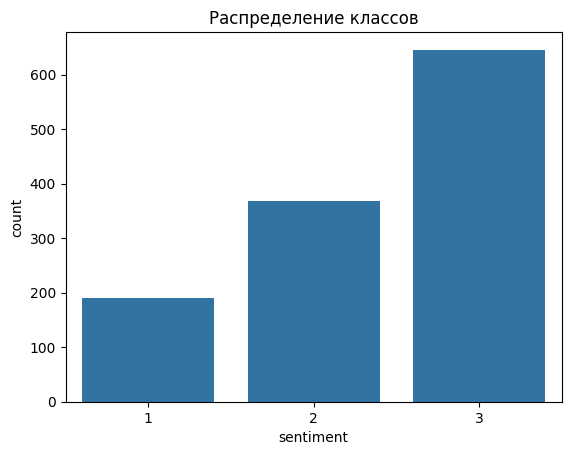

In [55]:
print("Распределение классов:")
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title('Распределение классов')
plt.show()

In [56]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
        words = text.split()
        words = [morph.parse(word)[0].normal_form for word in words if word.lower() not in stop_words]  # Удаление стоп-слов и лемматизация
        return ' '.join(words)
    return ''
df['tweet'] = df['tweet'].apply(preprocess_text)
df['sentiment'] = df['sentiment'] - 1
print("Уникальные значения меток:")
print(df['sentiment'].unique())

Уникальные значения меток:
[1 2 0]


In [57]:
X = df['tweet']
y = df['sentiment']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание пайплайна для TF-IDF и XGBoost
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', xgb.XGBClassifier(objective='multi:softmax', num_class=3))
])

# Определение параметров для Grid Search
parameters = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1]
}

In [58]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
print("Лучшие параметры для XGBoost:")
print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)

y_test = y_test + 1
y_pred = y_pred + 1

print("Отчет по классификации для XGBoost:")
print(classification_report(y_test, y_pred))

# Кросс-валидация для оценки качества модели
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='f1_weighted')
print(f'Cross-Validation scores: {cv_scores}')
print(f'Mean Cross-Validation score: {cv_scores.mean()}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры для XGBoost:
{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'tfidf__max_df': 1.0, 'tfidf__ngram_range': (1, 1)}
Отчет по классификации для XGBoost:
              precision    recall  f1-score   support

           1       0.56      0.24      0.33        38
           2       0.58      0.30      0.39        74
           3       0.63      0.91      0.74       129

    accuracy                           0.61       241
   macro avg       0.59      0.48      0.49       241
weighted avg       0.60      0.61      0.57       241

Cross-Validation scores: [0.49805961 0.53252603 0.4397699  0.54584394 0.51284438]
Mean Cross-Validation score: 0.5058087735419705


Выводы:
Точность - Средний результат
Macro avg F1-score: 0.49 – Низкий результат. Модель не очень хорошо сбалансирована по всем классам
Weighted avg F1-score: 0.57 – Средний результат. Взвешенная F1-оценка также средняя, что указывает на умеренную общую производительность модели.
Кросс-валидационные оценки: от 0.44 до 0.55 с средней оценкой 0.51 – Средний результат. Модель показывает стабильную, но не выдающуюся производительность при кросс-валидации.
Общая оценка:
Результаты модели можно считать средними